In [1]:
! pip install -qU wandb pytesseract

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/feature-extraction-dataset/train.csv")
df.head()

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram


In [3]:
import os
import requests
import logging

import torch
import pytesseract
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', clean_up_tokenization_spaces=True)

def get_token_id(word):
    token_id = tokenizer.encode(word, add_special_tokens=False)
    if token_id:
        return token_id[0]
    else:
        raise Exception("Word not found")


class ProductFeatures(Dataset):
    def __init__(self, 
                 csv_path: str, 
                 base_path: str, 
                 transforms: transforms.transforms.Compose, 
                 tokenizer: DistilBertTokenizer, 
                 max_length: int = 128):
        self.data = pd.read_csv(csv_path)
        self.base_path = base_path
        self.transforms = transforms
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.entity_name_to_idx = {}
        for i, entity_name in enumerate(self.data["entity_name"].unique().tolist()):
            self.entity_name_to_idx[entity_name] = i

    def __len__(self) -> int:
        return self.data.shape[0]
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Load the image
        image_name = os.path.basename(self.data["image_link"][index])
        try:
            image = Image.open(os.path.join(self.base_path, image_name))
        except:
            image = Image.open(requests.get(self.data["image_link"][index], stream=True).raw)
            
        image_tensor = self.transforms(image)
        
        # Load the entity_name
        entity_idx = self.entity_name_to_idx[self.data["entity_name"][index]]
        entity_tensor = torch.tensor([entity_idx])
        
        # Extract and tokenize the text from the image
        text = pytesseract.image_to_string(image)
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True, 
            max_length=self.max_length
        )
        input_ids = inputs["input_ids"].squeeze(0)  # Shape: (max_length,)
        attention_mask = inputs["attention_mask"].squeeze(0)  # Shape: (max_length,)
        
        # Tokenize the outputs (target)
        target = self.data["entity_value"][index].split()[:2]
        target_idx = list(map(get_token_id, target))
        target_tensor = torch.tensor(target_idx)
        
        return image_tensor, entity_tensor, input_ids, attention_mask, target_tensor


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [4]:
# import os
# import logging

# import torch
# import pytesseract
# import pandas as pd
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader
# from transformers import DistilBertModel, DistilBertTokenizer

# loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
# for logger in loggers:
#     if "transformers" in logger.name.lower():
#         logger.setLevel(logging.ERROR)


# class ProductFeatures(Dataset):
#     def __init__(self, 
#                  csv_path: str, 
#                  base_path: str, 
#                  transforms: transforms.transforms.Compose):
#         self.data = pd.read_csv(csv_path)
#         self.base_path = base_path
#         self.transforms = transforms
        
#         self.entity_name_to_idx = {}
#         for i, entity_name in enumerate(self.data["entity_name"].unique().tolist()):
#             self.entity_name_to_idx[entity_name] = i
            
#         self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
#         self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', clean_up_tokenization_spaces=True)
            
        
#     def __len__(self) -> int:
#         return self.data.shape[0]
    
#     def __getitem__(self, 
#                     index: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         # Load the image
#         image_name = os.path.basename(self.data["image_link"][index])
#         image = Image.open(os.path.join(self.base_path, image_name))
#         image_tensor = self.transforms(image)
        
#         # Load the entity_name
#         entity_idx = self.entity_name_to_idx[self.data["entity_name"][index]]
#         entity_tensor = torch.tensor([entity_idx])
        
#         # Extract and process the text from the image
#         text = pytesseract.image_to_string(image)
#         inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
#         text_embeddings = self.bert(**inputs)[0].squeeze(0)
#         print(text_embeddings.shape)
        
#         # Tokenize the outputs
#         target = self.data["entity_value"][index].split()[:2]
#         target_idx = list(map(get_token_id, target))
#         target_tensor = torch.tensor(target_idx)
        
#         return image_tensor, entity_tensor, text_embeddings, target_tensor

In [5]:
# from torch import nn
# from torchvision import models


# class FeatureExtractionModel(nn.Module):
#     def __init__(self, num_output_words: int = 2):
        
#         super().__init__()
        
#         resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#         self.image_encoder = nn.Sequential(*list(resnet.children())[:-1]) 
        
#         text_embedding_size = 768
#         image_embedding_size = 2048
#         entity_idx_size = 1
#         combined_size = text_embedding_size + image_embedding_size + entity_idx_size
        
#         self.fc = nn.Linear(combined_size, num_output_words * 30522)
        
#     def forward(self, 
#                 image: torch.Tensor, 
#                 entity_idx: torch.Tensor, 
#                 text_embeddings: torch.Tensor):
        
#         image_embeddings = self.image_encoder(image).view(image.size(0), -1)
#         combined_embeddings = torch.cat((text_embeddings, image_embeddings, entity_idx), dim=1)
#         logits = self.fc(combined_embeddings)
#         logits = logits.view(logits.size(0), 2, 30522)
        
#         return logits

In [6]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False)
])

dataset = ProductFeatures(
    csv_path="/kaggle/input/feature-extraction-dataset/train.csv",
    base_path="/kaggle/input/amazonmlchallenge",
    transforms=transforms,
    tokenizer=tokenizer
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=32
)

In [7]:
import time

start = time.time()
next(iter(dataloader))
end = time.time()

end - start

27.53539276123047

(-0.5, 223.5, 223.5, -0.5)

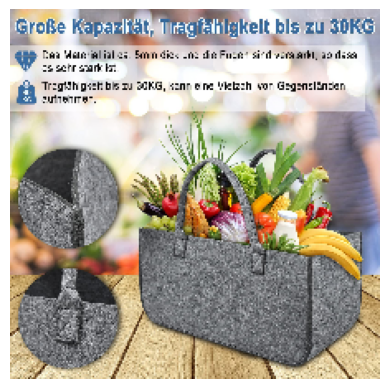

In [8]:
import matplotlib.pyplot as plt

plt.imshow(dataset[10][0].permute(1, 2, 0))
plt.axis('off')

In [9]:
from torch import nn
from torchvision import models


class FeatureExtractionModel(nn.Module):
    def __init__(self, num_output_words: int = 2, max_length: int = 128):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device) 
        for param in self.bert.parameters():
            param.requires_grad = False
        
        text_embedding_size = 768
        image_embedding_size = 2048
        entity_idx_size = 1
        combined_size = text_embedding_size + image_embedding_size + entity_idx_size
        self.fc = nn.Linear(combined_size, num_output_words * 30522)
        
    def forward(self, 
                image: torch.Tensor, 
                entity_idx: torch.Tensor, 
                input_ids: torch.Tensor, 
                attention_mask: torch.Tensor):
        
        image_embeddings = self.image_encoder(image).view(image.size(0), -1)
        
        text_embeddings = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]  # CLS token
        
        combined_embeddings = torch.cat((text_embeddings, image_embeddings, entity_idx), dim=1)
        
        logits = self.fc(combined_embeddings)
        logits = logits.view(logits.size(0), 2, 30522)
        
        return logits

In [10]:
model = FeatureExtractionModel()
model.to(device)
data = next(iter(dataloader))
model(data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

torch.Size([32, 2, 30522])

In [11]:
from torch import optim
from tqdm import tqdm

model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    total_loss = 0
    
    for i, (image, entity, input_ids, attention_mask, target) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        
        logits = model(
            image.to(device), 
            entity.to(device), 
            input_ids.to(device),
            attention_mask.to(device)
        )
        
        target_word1 = target[:, 0].to(device)  # First word
        target_word2 = target[:, 1].to(device)  # Second word
        
        loss_word1 = criterion(logits[:, 0, :], target_word1)
        loss_word2 = criterion(logits[:, 1, :], target_word2)
        
        loss = loss_word1 + loss_word2
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        if i % 10 == 9:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/10}")
            total_loss = 0
            torch.save(model.state_dict(), f"{epoch}_{i}_{total_loss/10}")

9it [03:31, 23.58s/it]

Epoch [1/10], Loss: 20.437846755981447


16it [06:10, 23.16s/it]
